## Working with WMS

In this notebook, I would like to check what services are available from the GNS mapping services. WFS services are surely available, the problem is that they can not be put into work with cartopy. There is still hope in downloading the data first as gml or geojson and then load them using cartopy.shapely

In [1]:
from owslib.wms import WebMapService
from IPython.core.display import HTML

In [2]:
qmap_wms_url = r"https://gis.gns.cri.nz/server/services/NZL_GNS_250K_Geology_2020/NZL_GNS_250K_geology_WMS/MapServer/WmsServer?"
wms = WebMapService(qmap_wms_url)
print("Title: ", wms.identification.title)
print("Type: ", wms.identification.type)
print("Operations: ", [op.name for op in wms.operations])
print("GetMap options: ", wms.getOperationByName('GetMap').formatOptions)
wms.contents.keys()

Title:  NZL_GNS_250K_Geology_2020_NZL_GNS_250K_geology_WMS
Type:  WMS
Operations:  ['GetCapabilities', 'GetMap', 'GetFeatureInfo', 'GetStyles']
GetMap options:  ['image/bmp', 'image/jpeg', 'image/tiff', 'image/png', 'image/png8', 'image/png24', 'image/png32', 'image/gif', 'image/svg+xml']


odict_keys(['1', '2', '3', '4', '7', '9', '10', '11', '12', '13', '14', '15', '17', '18', '20', '22', '24', '25', '27', '28', '30', '32', '34', '36', '38', '40', '42', '45', '47', '48', '49', '50', '51', '52', '53', '54', '56', '57', '58', '60', '62', '64', '65', '67', '69', '71', '72', '75', '76', '78', '79', '81', '84', '86', '88', '90', '92', '94', '96', '98', '100'])

In [3]:
for key in wms.contents.keys():
    print(str(key)+" "+wms.contents[key].title)

1 NIWA_dem
2 NIWA_shademodel
3 Mainland_ShadeModel
4 Chathams_ShadeModel
7 NZL_CIT_GNS_250K_sources
9 NZL_CIT_GNS_250K_geological_units
10 NZL_CIT_GNS_250K_geological_units (simplified)
11 NZL_CIT_GNS_250K_topographic_units
12 NZL_CIT_GNS_250K_textural_zones (overprint)
13 NZL_CIT_GNS_250K_topographic_boundaries
14 NZL_CIT_GNS_250K_topographic_boundaries (coastline)
15 NZL_CIT_GNS_250K_geological_boundaries
17 Road_Centrelines__Topo__1_250k
18 River_Centrelines__Topo__1_250k
20 Default
22 Default
24 NZL_CIT_GNS_250K_landslide_units
25 NZL_CIT_GNS_250K_landslide_boundaries
27 NZL_CIT_GNS_250K_folds
28 NZL_CIT_GNS_250K_folds (symbols)
30 NZL_CIT_GNS_250K_faults
32 FaultName
34 NZL_CIT_GNS_250K_dikes
36 NZL_CIT_GNS_250K_structural_data
38 DipOrPlunge
40 NZL_CIT_GNS_250K_resources
42 Commodity
45 NZL_GNS_250K_sources
47 NZL_GNS_250K_geological_units
48 NZL_GNS_250K_geological_units (simplified)
49 NZL_GNS_250K_topographic_units
50 NZL_GNS_250K_textural_zones (overprints)
51 NZL_GNS_250K_to

In [4]:
name = '3'
layer = wms.contents[name]
print("Abstract: ", layer.abstract)
print("BBox: ", layer.boundingBoxWGS84)
print("CRS: ", layer.crsOptions)
print("Styles: ", layer.styles)
print("Timestamps: ", layer.timepositions)
HTML(layer.parent.abstract)

Abstract:  This data layer represents a hillshade model for New Zealand. It is derived from the NZ 8m Digital Elevation Model (2012) obtained from the LINZ Data Service, originally created by Geographx (geographx.co.nz), using an azimuth of 315 degrees and an angle of inclination of the sun of 45 degrees above the horizon. This model is suitable for cartographic visualisation only.
BBox:  (166.232129, -47.437263, 179.525772, -33.969145)
CRS:  ['EPSG:2193', 'EPSG:4326']
Styles:  {'default': {'title': 'Mainland_ShadeModel', 'legend': 'https://gis.gns.cri.nz/server/services/NZL_GNS_250K_Geology_2020/NZL_GNS_250K_geology_WMS/MapServer/WmsServer?request=GetLegendGraphic%26version=1.1.1%26format=image/png%26layer=3'}}
Timestamps:  None


<IPython.core.display.HTML object>

In [5]:
bbox=(174.743, -36.892, 175.020, -36.672)
dim=(abs(bbox[2]-bbox[0]), abs(bbox[3]-bbox[1]))
max_dim=max(dim)
max_idx=dim.index(max_dim)
img_dim=1000
size=(img_dim*dim[0]/dim[max_idx], img_dim*dim[1]/dim[max_idx])

In [6]:
response = wms.getmap(layers=[name,],
                      styles=['default'],
                      bbox=bbox,
                      # Left, bottom, right, top
                      size=size,
                      format='image/png',
                      srs='EPSG:4326',
                      transparent=False)
response

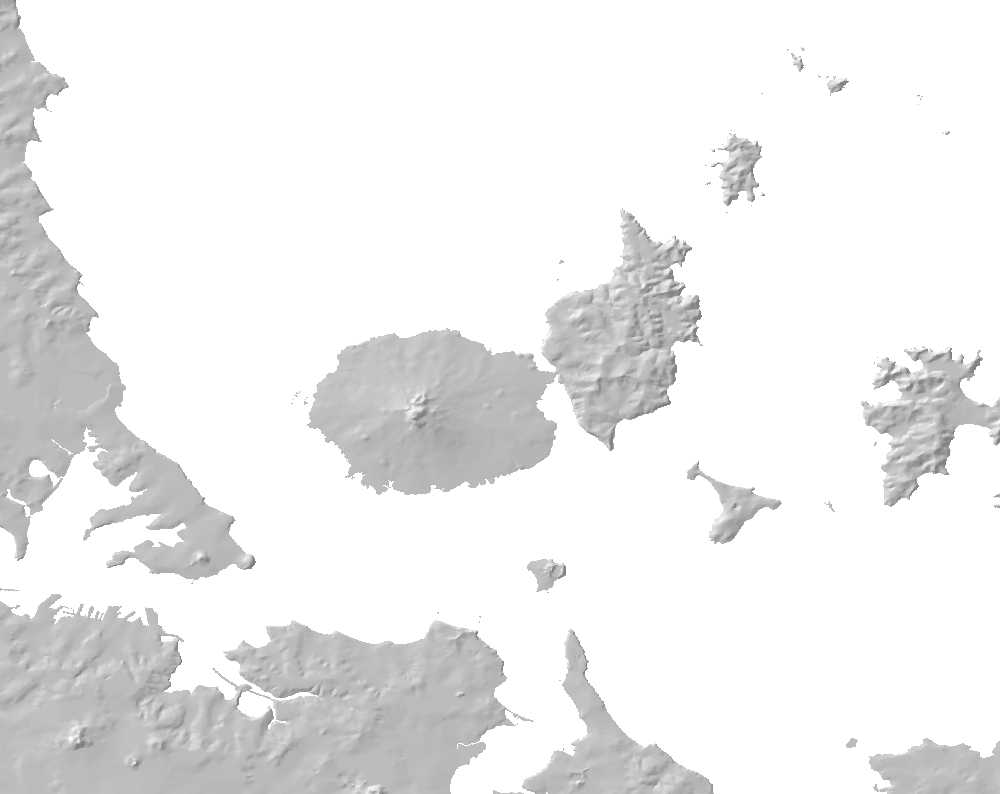

In [7]:
from IPython.display import Image
Image(response.read())

## Working with WFS

In [8]:
from owslib.wfs import WebFeatureService
import json
from shapely.geometry import shape, Polygon, LineString, MultiLineString, MultiPolygon
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.img_tiles as cimgt
import pyproj
import numpy as np
import requests
import base64
import io
import PIL

def most_common_color(base64_string):
    """
    extract the most common color from a base64 encoded png image
    as rgba tuple (with values in the range [0-1])
    
    Parameters
    ----------
    base64_string : str
        the base64 string.

    Returns
    -------
    most_common_color : tuple
        a rgba tuple of the most common color in the image.

    """
    img = base64.b64decode(base64_string)
    img = io.BytesIO(img)
    img = PIL.PngImagePlugin.PngImageFile(img)
    colors = img.getcolors()
    
    _, most_common_color = max(colors, key=lambda x: x[0])
    return tuple(i/255 for i in most_common_color)

def spliter(s,sep,ind):
    indx_locs=[i for i,j in enumerate(s) if j==sep]
    if len(indx_locs) <= ind:
        return s
    else:
        indx=indx_locs[ind-1]
        return s[:indx]+'\n'+s[indx+1:]

QMAP_wfs_url = r'https://gis.gns.cri.nz/server/services/NZL_GNS_250K_Geology_2020/NZL_GNS_250K_geology_WFS/MapServer/WFSServer?'

# Connect to GeoServer WFS service.
wfs = WebFeatureService(QMAP_wfs_url, version='2.0.0')

# Print the list of available layers
sorted(wfs.contents.keys())

['NZL_GNS_250K_Geology_2020_NZL_GNS_250K_geology_WFS:NZL_CIT_GNS_250K_dikes',
 'NZL_GNS_250K_Geology_2020_NZL_GNS_250K_geology_WFS:NZL_CIT_GNS_250K_faults',
 'NZL_GNS_250K_Geology_2020_NZL_GNS_250K_geology_WFS:NZL_CIT_GNS_250K_folds',
 'NZL_GNS_250K_Geology_2020_NZL_GNS_250K_geology_WFS:NZL_CIT_GNS_250K_geological_boundaries',
 'NZL_GNS_250K_Geology_2020_NZL_GNS_250K_geology_WFS:NZL_CIT_GNS_250K_geological_units',
 'NZL_GNS_250K_Geology_2020_NZL_GNS_250K_geology_WFS:NZL_CIT_GNS_250K_landslide_boundaries',
 'NZL_GNS_250K_Geology_2020_NZL_GNS_250K_geology_WFS:NZL_CIT_GNS_250K_landslide_units',
 'NZL_GNS_250K_Geology_2020_NZL_GNS_250K_geology_WFS:NZL_CIT_GNS_250K_metamorphic_boundaries',
 'NZL_GNS_250K_Geology_2020_NZL_GNS_250K_geology_WFS:NZL_CIT_GNS_250K_metamorphic_units',
 'NZL_GNS_250K_Geology_2020_NZL_GNS_250K_geology_WFS:NZL_CIT_GNS_250K_resources',
 'NZL_GNS_250K_Geology_2020_NZL_GNS_250K_geology_WFS:NZL_CIT_GNS_250K_sources',
 'NZL_GNS_250K_Geology_2020_NZL_GNS_250K_geology_WFS:N

In [9]:
sorted_layer_ids = list(sorted(wfs.contents.keys()))
idx_name = r'NZL_GNS_250K_Geology_2020_NZL_GNS_250K_geology_WFS:NZL_GNS_250K_topographic_boundaries'
NZ_shoreline_index = sorted_layer_ids.index(idx_name)

for layerID in sorted_layer_ids[NZ_shoreline_index - 1:NZ_shoreline_index + 2]:
    layer = wfs[layerID]
    print('Layer ID:', layerID)
    print('Title:', layer.title)
    print('Boundaries:', layer.boundingBoxWGS84, '\n')

Layer ID: NZL_GNS_250K_Geology_2020_NZL_GNS_250K_geology_WFS:NZL_GNS_250K_textural_zones
Title: NZL_GNS_250K_textural_zones
Boundaries: (168.00022776, -46.30489089, 178.78495151, -34.85667507) 

Layer ID: NZL_GNS_250K_Geology_2020_NZL_GNS_250K_geology_WFS:NZL_GNS_250K_topographic_boundaries
Title: NZL_GNS_250K_topographic_boundaries
Boundaries: (166.26202592, -47.42175346, 179.50120606, -34.00812266) 

Layer ID: NZL_GNS_250K_Geology_2020_NZL_GNS_250K_geology_WFS:NZL_GNS_250K_topographic_units
Title: NZL_GNS_250K_topographic_units
Boundaries: (166.33909372, -47.20954432, 179.21961944, -34.32927601) 



In [10]:
layer_id = 'NZL_GNS_250K_Geology_2020_NZL_GNS_250K_geology_WFS:NZL_GNS_250K_topographic_boundaries'
meta = wfs.contents[layer_id]
print(meta.title)

# Get the actual data
shore_wfs_call = wfs.getfeature(typename=layer_id, bbox=bbox, outputFormat='GEOJSON')

# Write to file
json_fname = r'NZ_shoreline.json'
with open(json_fname, 'wb') as json_fhead:
    json_fhead.write(shore_wfs_call.read())

NZL_GNS_250K_topographic_boundaries


We need the help of JSON and shapely here. Shapely script are [modified from here,](https://stackoverflow.com/questions/68820085/how-to-convert-geojson-to-shapely-polygon) while the [JSON stuffs come from here.](https://stackoverflow.com/questions/42753745/how-can-i-parse-geojson-with-python) You also need to understand that NZ shoreline is a multilinestring object that need to be parsed by shapely.geometry.MultiLineString in the form of [list of tuples of coordinate tuple.](https://shapely.readthedocs.io/en/stable/manual.html#collections-of-lines) See how to convert list (from JSON) into tuples [here.](https://www.geeksforgeeks.org/python-convert-nested-sublist-into-tuples/)

In [11]:
#Transform the WGS84 EPSG:4326 to EPSG:2193
wgs84_to_nztm00 = pyproj.Transformer.from_crs("EPSG:4326", "EPSG:2193")

json_file = open(json_fname)
shore_data = json.load(json_file)
json_file.close()
feature_num = len(shore_data['features'])
shoreLine_XY =  ['']*feature_num
for feature in range(feature_num):
    geometry = shore_data['features'][feature]['geometry']
    num_vertex = np.shape(geometry['coordinates'][0])[0]
    nztm_vert = ['']*num_vertex
    for i in range(num_vertex):
        lat, long = geometry['coordinates'][0][i]
        nztm_y, nztm_x = wgs84_to_nztm00.transform(lat, long)
        nztm_vert[i] = [nztm_x, nztm_y]
    shoreLine_XY[feature] = tuple(tuple(vert) for vert in nztm_vert)

print(shoreLine_XY[:3])
shore_poly = MultiLineString(shoreLine_XY) #it is a line string!

[((1776064.9546326625, 5924066.590201879), (1776014.918724901, 5924082.986265578), (1776014.448732384, 5924166.480306294), (1776031.3628339767, 5924166.517374154), (1776064.4431223029, 5924166.590204666), (1776064.9546326625, 5924066.590201879)), ((1772473.9878425323, 5925522.663356323), (1772407.4520733787, 5925539.030239049), (1772390.5148951928, 5925605.486534548), (1772457.0505489393, 5925589.130918087), (1772473.1485033021, 5925525.959057337), (1772473.9878425323, 5925522.663356323)), ((1777199.8878985664, 5925983.15999253), (1777193.5950949588, 5925984.390670899), (1777170.7976677055, 5925988.848913633), (1777147.8401833067, 5925993.338166757), (1777136.0759864228, 5925995.635870069), (1777116.357231948, 5925999.486158391), (1777116.2825495931, 5926032.480225103), (1777133.9344897054, 5926041.383033103), (1777136.7409965438, 5926042.797681591), (1777183.0164878257, 5926066.12382327), (1777199.8878985664, 5925983.15999253))]


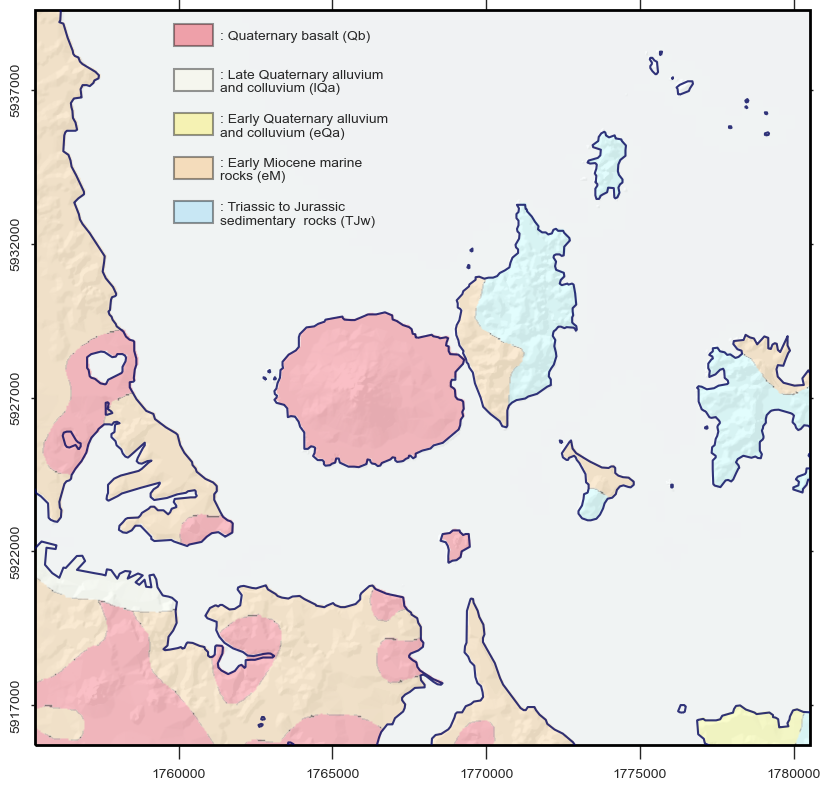

In [12]:
# MAP PLOTTING

bounds_A = wgs84_to_nztm00.transform(bbox[1], bbox[0])
bounds_B = wgs84_to_nztm00.transform(bbox[3], bbox[2])
bounds = (bounds_A[1], bounds_B[1], bounds_A[0], bounds_B[0])

mpl.style.use('seaborn')

fig = plt.figure(figsize=(10, 10), dpi= 100, facecolor='white', edgecolor='k')
ax = fig.add_subplot(111, projection=ccrs.epsg(2193))
ax.set_extent(bounds, crs=ccrs.epsg(2193))

#WMS
qmap_wms_url = r"https://gis.gns.cri.nz/server/services/NZL_GNS_250K_Geology_2020/NZL_GNS_250K_geology_WMS/MapServer/WMSServer?"
qmap_wms_url_1M = r"https://gis.gns.cri.nz/server/services/Geological_Map_of_New_Zealand_1_Million/NZL_GNS_1M_geology_WMS/MapServer/WMSServer?"
#WMTS
LINZ_hillshade = cimgt.LINZMapsTiles('204ef2d70f804850b2ceff69ac5525ed','50765')

#add NIWA shademodel
#ax.add_wms(wms=qmap_wms_url, layers=['2'],
#           wms_kwargs={'transparent':True},
#           transform=ccrs.epsg(2193), alpha=0.5)

#rect = ax.patch
#rect.set_facecolor("xkcd:light blue")

#add shademodel
#ax.add_wms(wms=qmap_wms_url, layers=['3'],
#           wms_kwargs={'transparent':True},
#           transform=ccrs.epsg(2193), alpha=1)
#gettile_extra_kwargs={'tilematrixset':'EPSG:2193'}

ax.add_image(LINZ_hillshade, 13,  alpha=0.4)

#add NIWA sea
ax.add_wms(wms=qmap_wms_url, layers=['1'],
           wms_kwargs={'transparent':True},
           transform=ccrs.epsg(2193), alpha=0.7)

#add geologic map
#for 250K: 47 is geological map full version, #48 is geological map simplified version
#for 1M: 7 is geological map full version

ax.add_wms(wms=qmap_wms_url_1M, layers=['7'], 
           wms_kwargs={'transparent':False},
           transform=ccrs.epsg(2193), alpha=0.8)

#add geologic boundary
#for 250K: 53 is geological boundary
#for 1M: 9 is is geological boundary
ax.add_wms(wms=qmap_wms_url_1M, layers=['9'], 
           wms_kwargs={'transparent':True},
           transform=ccrs.epsg(2193), alpha=0.7)

ax.add_geometries([shore_poly], crs=ccrs.epsg(2193),
                  facecolor='None', edgecolor='xkcd:dark blue',
                  linewidth=1.5, alpha=0.8, zorder=5)

plt.tick_params(bottom=True,top=True,left=True,right=True,
                labelbottom=True,labeltop=False,labelleft=True,
                labelright=False)

ax.xaxis.set_visible(True)
ax.yaxis.set_visible(True)
ax.ticklabel_format(style='plain')
ax.tick_params(axis='y', labelrotation=90, labelsize=10, length=2)
ax.tick_params(axis='x', labelsize=10, length=10)
txt = ax.get_yticks()+2000
ax.yaxis.set_major_locator(mpl.ticker.FixedLocator(txt.tolist()))
ax.set_yticklabels(['{:.0f}'.format(y) for y in txt.tolist()], verticalalignment='center')
ax.grid(False)

for _,s in ax.spines.items():
    s.set_linewidth(2)
    s.set_color('black')
    
# LEGEND PLOTTING

qmap_wms_serv = WebMapService(qmap_wms_url_1M)
#qmap_legend_title = qmap_wms_serv['48'].styles['default']['title']
qmap_legend_title = qmap_wms_serv['7'].styles['default']['title']
#qmap_legend_json = r"https://data.gns.cri.nz/server/rest/services/NZL_GNS_250K_Geology_2020/NZL_GNS_250K_geology_WMS/MapServer/legend?dynamicLayers=%5B327%5D&f=pjson"
qmap_legend_json = r"https://data.gns.cri.nz/server/rest/services/Geological_Map_of_New_Zealand_1_Million/NZL_GNS_1M_geology_WMS/MapServer/legend?f=pjson"
qmap_legend_list = json.loads(requests.get(qmap_legend_json).content.decode())
qmap_layer_num = len(qmap_legend_list["layers"])

for i in range(qmap_layer_num):
    layerName = qmap_legend_list['layers'][i]['layerName']
    if layerName == qmap_legend_title:
        geol_unit_legend = qmap_legend_list['layers'][i]['legend']
        break
        
#print(qmap_legend_title)
#print(layerName)
#print(geol_unit_legend)
geol_unit_item = len(geol_unit_legend)
geol_unit_shown = ['eM', 'TJw', 'Qb', 'lQa', 'eQa']

# extract legend colors from legend-image data
layer_legend = [""]*len(geol_unit_shown)
legend_idx=0
legend_icon_h = geol_unit_legend[i]['height']
legend_icon_w = geol_unit_legend[i]['width']
legend_origin = np.array([0.18, 0.95]) #axes.TransAxes
for i in range(geol_unit_item):
    if geol_unit_legend[i]['values'][0] in geol_unit_shown:
        layer_legend[legend_idx]=geol_unit_legend[i]
        fc_colour = most_common_color(layer_legend[legend_idx]["imageData"])
        item_patch=plt.Rectangle((legend_origin[0], legend_origin[1]), 0.05, 0.03,
                                 facecolor=fc_colour, edgecolor='black',transform=ax.transAxes,
                                 linewidth=1.5, alpha=0.4)
        legend_txt = ": "+spliter(layer_legend[legend_idx]["label"], ' ', 3)
        ax.add_patch(item_patch)
        ax.text(legend_origin[0]+0.06, legend_origin[1]+0.015, legend_txt,
               fontsize=10, transform=ax.transAxes, verticalalignment='center_baseline')
        legend_idx+=1        
        legend_origin=legend_origin-np.array([0,0.06])
legend = {i["label"] : most_common_color(i["imageData"]) for i in layer_legend}